<a href="https://colab.research.google.com/github/Kshitij09/Forest-Fire-Detection/blob/master/keras_training_forest_fire_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Gathering and preprocessing

In [0]:
!pip install tensorflow-gpu==2.0.0

In [0]:
!pip install tensorflow_addons

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub

     |████████████████████████████████| 92kB 4.9MB/s 


**Dataset is currently kept on personal drive and will be made available once finalized**

In [0]:
!cp /content/drive/My\ Drive/Forest-Fire-Detection/train.tar.xz /tmp/forest-fire-train.tar.xz
!cp /content/drive/My\ Drive/Forest-Fire-Detection/test.tar.xz /tmp/forest-fire-test.tar.xz
!tar -xf /tmp/forest-fire-train.tar.xz
!tar -xf /tmp/forest-fire-test.tar.xz

In [0]:
train_dir = "/content/train"
test_dir = "/content/test"

In [14]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Define input_shape for every model
# input_shape = (224,224)
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2,
                             dtype=np.float32,
                            featurewise_center=False,  # set input mean to 0 over the dataset
                            samplewise_center=False,  # set each sample mean to 0
                            #featurewise_std_normalization=False,  # divide inputs by std of the dataset
                            #samplewise_std_normalization=False,  # divide each input by its std
                            # zca_whitening=True,  # apply ZCA whitening
                            #rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                            # brightness_range=[0.5,1.5],
                            zoom_range = 0.25, # Randomly zoom image 
                            width_shift_range=0.05,  # randomly shift images horizontally (fraction of total width)
                            height_shift_range=0.05,  # randomly shift images vertically (fraction of total height)
                            horizontal_flip=True,  # randomly flip images
                            vertical_flip=False)    # randomly flip images


train_datagen = datagen.flow_from_directory(train_dir,
                                           subset='training',
                                           batch_size=8,
                                           shuffle=True,
                                           seed=47,
                                           target_size=input_shape,
                                           class_mode='categorical')

validation_datagen = datagen.flow_from_directory(train_dir,
                                           subset='validation',
                                           batch_size=8,
                                           shuffle=True,
                                           seed=47,
                                           target_size=input_shape,
                                           class_mode='categorical')

test_generator = ImageDataGenerator(rescale=1./255)

test_datagen = test_generator.flow_from_directory(test_dir,
                                                  target_size=input_shape,
                                                  batch_size=1,
                                                  class_mode='categorical')

Found 303 images belonging to 4 classes.
Found 75 images belonging to 4 classes.
Found 93 images belonging to 4 classes.


In [16]:
labels = dict([(value, key) for key, value in validation_datagen.class_indices.items()])
print(labels)

{0: 'cloud', 1: 'fire', 2: 'fumes', 3: 'non-fire'}


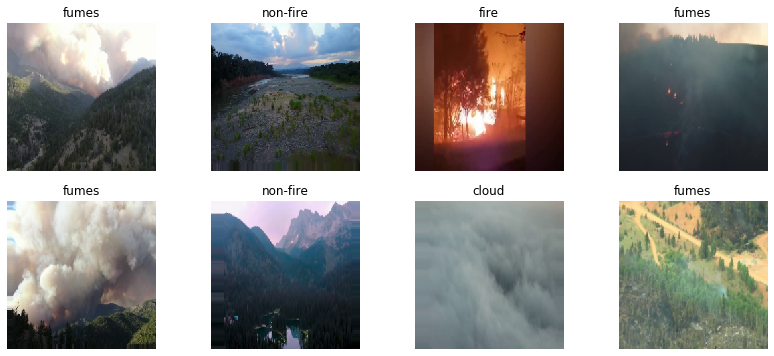

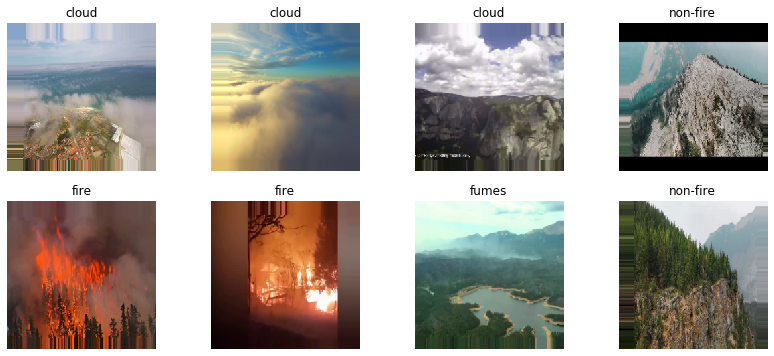

In [17]:
import matplotlib.pyplot as plt

def show_batches(n, generator):
  for _ in range(n):
    xs, ys = next(generator)

    lbl = lambda pred: labels[np.argmax(pred,axis=0)]

    cols = 4
    rows = xs.shape[0] // cols
    f, axs = plt.subplots(rows, cols, figsize=(14,6))
    for x, y,ax in zip(xs, ys, axs.flatten()):
      ax.imshow(x)
      ax.set_title(lbl(y))
      ax.axis('off')

show_batches(2, train_datagen)

# Defining Model

In [0]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam

## Inception-v3

In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

input_shape = (150,150)

pre_trained_model = InceptionV3(input_shape = input_shape + (3,), 
                                include_top = False, 
                                weights = None)

In [0]:
pre_trained_model.load_weights(local_weights_file)

In [ ]:
pre_trained_model.summary()

In [235]:
# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False


last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 3, 3, 1280)


Inceptionv3 Model works better with no extra layers. Exploring various approaches to improve the accuracy.

In [ ]:
last_output = last_layer.output

x = layers.Flatten()(last_output)

# x = layers.BatchNormalization()(last_output)
# gap = layers.GlobalAveragePooling2D()(x)
# gmp = layers.GlobalMaxPooling2D()(x)

# x = layers.concatenate([gap,gmp])
# x = layers.Flatten()(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(512, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.5)(x)
x = layers.Dense(4, activation='softmax')(x)


model = Model(pre_trained_model.input, x) 

model.compile(optimizer = Adam(1e-3), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc', 'AUC'])

model.summary()

## MobileNet-v2

In [0]:
classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

In [0]:
input_shape = (224, 224)
num_classes =  4
model = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,), output_shape=[1280],
                   trainable=False),
    layers.Dense(num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])  # Batch input shape.

In [ ]:
model.compile(optimizer = Adam(1e-3), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc', 'AUC'])

model.summary()

## Resnet-50

In [0]:
input_shape = (224, 224)
num_classes = 4
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_50/feature_vector/1",
                   trainable=False),  # Can be True, see below.
    layers.Dense(num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])  # Batch input shape.

In [ ]:
model.compile(optimizer = Adam(1e-3), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc', 'AUC'])

model.summary()

# Training

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_reduction = ReduceLROnPlateau(monitor='val_acc',
                                 patience=3,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=1e-6)

In [0]:
model_name = "resnet50-dense-i2"
epochs = 15

In [0]:
!rm -rf ./checkpoints/{model_name} ./logs/{model_name} ./csv_logs/{model_name}.csv

In [0]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, CSVLogger

!mkdir -p checkpoints/{model_name}
# !mkdir csv_logs
!touch ./csv_logs/{model_name}.csv

tensorboard = TensorBoard(log_dir=f"./logs/{model_name}", write_graph=True)
checkpoints = ModelCheckpoint(f'./checkpoints/{model_name}/' + "cp--{val_acc:.4f}.ckpt",
                                 monitor="val_acc",
                                 save_best_only=True,
                                 verbose=1,
                                 save_weights_only=True)
csvlogger = CSVLogger(f'./csv_logs/{model_name}.csv', separator=',', append=True)

In [24]:
history = model.fit_generator(train_datagen,
                  validation_data = validation_datagen,
                  steps_per_epoch=train_datagen.samples // train_datagen.batch_size,
                  validation_steps=validation_datagen.samples // validation_datagen.batch_size,
                  epochs = epochs,
                  verbose = 1, 
                  callbacks=[lr_reduction, tensorboard, checkpoints, csvlogger])

Epoch 1/15
36/37 [============================>.] - ETA: 0s - loss: 1.0978 - acc: 0.4056 - AUC: 0.6970
Epoch 00001: val_acc improved from -inf to 0.77778, saving model to ./checkpoints/resnet50-dense-i2/cp--0.7778.ckpt
37/37 [==============================] - 31s 836ms/step - loss: 1.0783 - acc: 0.4128 - AUC: 0.7027 - val_loss: 0.6891 - val_acc: 0.7778 - val_AUC: 0.9203
Epoch 2/15
36/37 [============================>.] - ETA: 0s - loss: 0.5642 - acc: 0.7605 - AUC: 0.9305
Epoch 00002: val_acc improved from 0.77778 to 0.80556, saving model to ./checkpoints/resnet50-dense-i2/cp--0.8056.ckpt
37/37 [==============================] - 16s 438ms/step - loss: 0.5635 - acc: 0.7619 - AUC: 0.9312 - val_loss: 0.5791 - val_acc: 0.8056 - val_AUC: 0.9437
Epoch 3/15
36/37 [============================>.] - ETA: 0s - loss: 0.3746 - acc: 0.8825 - AUC: 0.9791
Epoch 00003: val_acc did not improve from 0.80556
37/37 [==============================] - 16s 428ms/step - loss: 0.3674 - acc: 0.8825 - AUC: 0.9790

# Evaluation and results

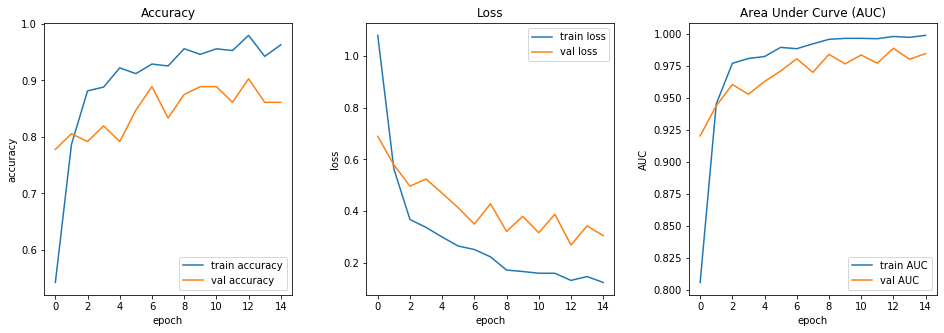

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
fig.subplots_adjust(wspace=0.3)
ax1.plot(history.history['acc'], label='train accuracy')
ax1.plot(history.history['val_acc'], label='val accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(loc='lower right')

ax2.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['val_loss'], label='val loss')
ax2.set_title('Loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.legend(loc='upper right');

ax3.plot(history.history['AUC'], label='train AUC')
ax3.plot(history.history['val_AUC'], label='val AUC')
ax3.set_title('Area Under Curve (AUC)')
ax3.set_xlabel('epoch')
ax3.set_ylabel('AUC')
ax3.legend(loc='lower right');

fig.savefig(f'{model_name}.png')

In [26]:
latest = tf.train.latest_checkpoint(f"checkpoints/{model_name}")
model.load_weights(latest)
loss, acc, auc = model.evaluate(test_datagen)
print(f"Restored Model, accuracy: {acc*100:3.2f}, auc: {auc*100:3.2f}")

93/93 [==============================] - 7s 77ms/step - loss: 0.4205 - acc: 0.8817 - AUC: 0.9672
Restored Model, accuracy: 88.17, auc: 96.72


In [0]:
!mkdir -p saved_models/h5 saved_models/tflite

In [0]:
model.save(f"saved_models/h5/{model_name}.h5")

In [286]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE, tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
# Set quantize to true 
# converter.post_training_quantize=True
tflite_model = converter.convert()

filename = f"saved_models/tflite/{model_name}.tflite"
open(filename, "wb").write(tflite_model)

23615912